In [2]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
import pandas as pd
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import LabelEncoder

warnings.simplefilter(action='ignore', category=FutureWarning)

In [3]:
df = pd.read_csv('dataset.csv')

## Vamos a limpiar el dataset de las columnas innecesarias y asi reducimos un poco tambien la dimensionalidad de las mas de 30 clases.


In [4]:
df.columns.values

array(['Customer ID', 'Gender', 'Age', 'Married', 'Number of Dependents',
       'City', 'Zip Code', 'Latitude', 'Longitude', 'Number of Referrals',
       'Tenure in Months', 'Offer', 'Phone Service',
       'Avg Monthly Long Distance Charges', 'Multiple Lines',
       'Internet Service', 'Internet Type', 'Avg Monthly GB Download',
       'Online Security', 'Online Backup', 'Device Protection Plan',
       'Premium Tech Support', 'Streaming TV', 'Streaming Movies',
       'Streaming Music', 'Unlimited Data', 'Contract',
       'Paperless Billing', 'Payment Method', 'Monthly Charge',
       'Total Charges', 'Total Refunds', 'Total Extra Data Charges',
       'Total Long Distance Charges', 'Total Revenue', 'Customer Status',
       'Churn Category', 'Churn Reason'], dtype=object)

### Vamos a eliminar columnas que a priori no queremos en nuestro dataset. y categorias que queremos evitar.

Por ejemplo, sabiendo que nuestra variable objetivo va a ser "Customer Status" Si nuestro cliente (se irá o no)... Incluir variables como churn Category o Churn Reason, corremos el riesgo de sobreajustar el modelo.

In [5]:
columns_del = ['Customer ID','City',
             'Latitude', 'Longitude','Avg Monthly Long Distance Charges',
             'Avg Monthly GB Download', 'Churn Reason', 'Churn Category']
df.drop(columns_del, axis=1, inplace=True)

In [6]:
columns_del = ['Zip Code']
df.drop(columns_del, axis=1, inplace=True)

### Vamos a trabajar un poco valores nulos y perdidos
- Offer                       3877 # No tienen aplicada ninguna oferta
- Multiple Lines               682 
- Internet Type               1526 
- Online Security             1526
- Online Backup               1526
- Device Protection Plan      1526
- Premium Tech Support        1526
- Streaming TV                1526
- Streaming Movies            1526
- Streaming Music             1526
- Unlimited Data              1526

### Vamos a ver que tipo de variables son binarias y cuales tienen muchas clases y valores muy variados.

In [9]:
num_valores_unicos = df.nunique()

# Mostrar el resultado
num_valores_unicos

Gender                            2
Age                              62
Married                           2
Number of Dependents             10
Number of Referrals              12
Tenure in Months                 72
Offer                             5
Phone Service                     2
Multiple Lines                    2
Internet Service                  2
Internet Type                     3
Online Security                   2
Online Backup                     2
Device Protection Plan            2
Premium Tech Support              2
Streaming TV                      2
Streaming Movies                  2
Streaming Music                   2
Unlimited Data                    2
Contract                          3
Paperless Billing                 2
Payment Method                    3
Monthly Charge                 1591
Total Charges                  6540
Total Refunds                   500
Total Extra Data Charges         16
Total Long Distance Charges    6068
Total Revenue               

### Columnas con caracteristicas binarias a las que podriamos aplicarle Label Encoder, esto es convertir Yes y No en 0 y 1 ya que los modelos de clasificación responder mejores a variables numéricas.
- 'Customer Status'
- 'Unlimited Data'
- 'Streaming Music'
- 'Streaming Movies'
- 'Premium Tech Support'
- 'Device Protection Plan'
- 'Online Backup'
- 'Online Security'
- 'Phone Service'            
- 'Multiple Lines'             
- 'Internet Service'
- 'Married'

In [10]:
# Juntemos Joined y stayed en una sola para mejorar nuestra variable objetivo
df['Customer Status'] = df['Customer Status'].replace({'Joined': 'Stayed'})

In [11]:
#convertir variables categoricas en variables numéricas
#churned 1
#stayed 0
label_encoder = LabelEncoder()
df['Customer Status'] = label_encoder.fit_transform(df['Customer Status'])

In [12]:
# Otras columnas binarias para LabelEncoder.
columnas = ['Streaming TV','Gender',
           'Married','Phone Service', 'Multiple Lines', 'Internet Service',
           'Online Security', 'Online Backup','Device Protection Plan',
            'Premium Tech Support', 'Streaming TV','Streaming Movies', 'Streaming Music',
            'Unlimited Data','Paperless Billing',]

for columna in columnas:
    df[columna] = label_encoder.fit_transform(df[columna])

In [13]:
df.columns.values

array(['Gender', 'Age', 'Married', 'Number of Dependents',
       'Number of Referrals', 'Tenure in Months', 'Offer',
       'Phone Service', 'Multiple Lines', 'Internet Service',
       'Internet Type', 'Online Security', 'Online Backup',
       'Device Protection Plan', 'Premium Tech Support', 'Streaming TV',
       'Streaming Movies', 'Streaming Music', 'Unlimited Data',
       'Contract', 'Paperless Billing', 'Payment Method',
       'Monthly Charge', 'Total Charges', 'Total Refunds',
       'Total Extra Data Charges', 'Total Long Distance Charges',
       'Total Revenue', 'Customer Status'], dtype=object)

In [14]:
nan_values = df.isnull().sum()
print(nan_values,'\n')

Gender                            0
Age                               0
Married                           0
Number of Dependents              0
Number of Referrals               0
Tenure in Months                  0
Offer                          3877
Phone Service                     0
Multiple Lines                    0
Internet Service                  0
Internet Type                  1526
Online Security                   0
Online Backup                     0
Device Protection Plan            0
Premium Tech Support              0
Streaming TV                      0
Streaming Movies                  0
Streaming Music                   0
Unlimited Data                    0
Contract                          0
Paperless Billing                 0
Payment Method                    0
Monthly Charge                    0
Total Charges                     0
Total Refunds                     0
Total Extra Data Charges          0
Total Long Distance Charges       0
Total Revenue               

#### Con internet type y Offer debemos aplicar otro tipo de encoding como Dummy o One Hot ya que tienen información que podria ser util para que el modelo aprenda mejor.

In [15]:
# Rellenando los valores Na de Offer ya que se refieren a personas qeu no tienen ninguna oferta.

df['Offer'].fillna(value='No Offer', inplace=True)

In [16]:
df['Offer'].value_counts()

Offer
No Offer    3877
Offer B      824
Offer E      805
Offer D      602
Offer A      520
Offer C      415
Name: count, dtype: int64

In [17]:
df['Multiple Lines'].value_counts()

Multiple Lines
0    3390
1    2971
2     682
Name: count, dtype: int64

In [18]:
df['Unlimited Data'].unique()

array([1, 0, 2])

In [19]:
df['Customer Status'].value_counts()

Customer Status
1    5174
0    1869
Name: count, dtype: int64

In [20]:
num_valores_unicos = df.nunique()

# Mostrar el resultado
num_valores_unicos

Gender                            2
Age                              62
Married                           2
Number of Dependents             10
Number of Referrals              12
Tenure in Months                 72
Offer                             6
Phone Service                     2
Multiple Lines                    3
Internet Service                  2
Internet Type                     3
Online Security                   3
Online Backup                     3
Device Protection Plan            3
Premium Tech Support              3
Streaming TV                      3
Streaming Movies                  3
Streaming Music                   3
Unlimited Data                    3
Contract                          3
Paperless Billing                 2
Payment Method                    3
Monthly Charge                 1591
Total Charges                  6540
Total Refunds                   500
Total Extra Data Charges         16
Total Long Distance Charges    6068
Total Revenue               

## Feature Engineering

Considero conveniente convertir Offer en una categoria Boleana de Offer = True Y No Offer = False esto ayuda a reducir ruido en el modelo

In [21]:
import pandas as pd

# Reemplazar los valores en la columna "Offer" por True (oferta) y False (sin oferta)
df['Offer'] = df['Offer'].replace({'Offer A': True, 'Offer B': True, 'Offer C': True,
                                   'Offer D': True, 'Offer E': True, 'No Offer': False})



In [22]:
df['Customer Status']

0       1
1       1
2       0
3       0
4       0
       ..
7038    1
7039    0
7040    1
7041    1
7042    1
Name: Customer Status, Length: 7043, dtype: int32

In [25]:
### Internet Type es una variable que podemos aplicarle un encoding para capturar
### Lo que nos quiere decir cada tipo de internet.
### Al igual que otras variables como Contract.
### A la que podemos sacarle mas informacion haciendo Encoding por tipo de contrato


print(df['Internet Type'])
print (df['Contract'])

0             Cable
1             Cable
2       Fiber Optic
3       Fiber Optic
4       Fiber Optic
           ...     
7038            DSL
7039    Fiber Optic
7040            DSL
7041          Cable
7042          Cable
Name: Internet Type, Length: 7043, dtype: object
0             One Year
1       Month-to-Month
2       Month-to-Month
3       Month-to-Month
4       Month-to-Month
             ...      
7038          One Year
7039    Month-to-Month
7040    Month-to-Month
7041          Two Year
7042          Two Year
Name: Contract, Length: 7043, dtype: object


#Encoding otras caracteristicas con mas de dos categorias. con One Hot Encoding de Pandas

[One Hot encoding en Pandas, get_dummies] (https://pandas.pydata.org/docs/reference/api/pandas.get_dummies.html)

In [26]:
#Encoding otras caracteristicas con mas de dos categorias. con One Hot Encoding

df = pd.get_dummies(df)

### Primer vistazo después de aplicar OneHotEncoding, a través de get.dummies de Pandas

In [29]:
# Comprobación de la correlación entre características
import pandas as pd
import matplotlib.pyplot as plt

# Calcula la matriz de correlación
correlation_matrix = df.corr()

<Axes: >

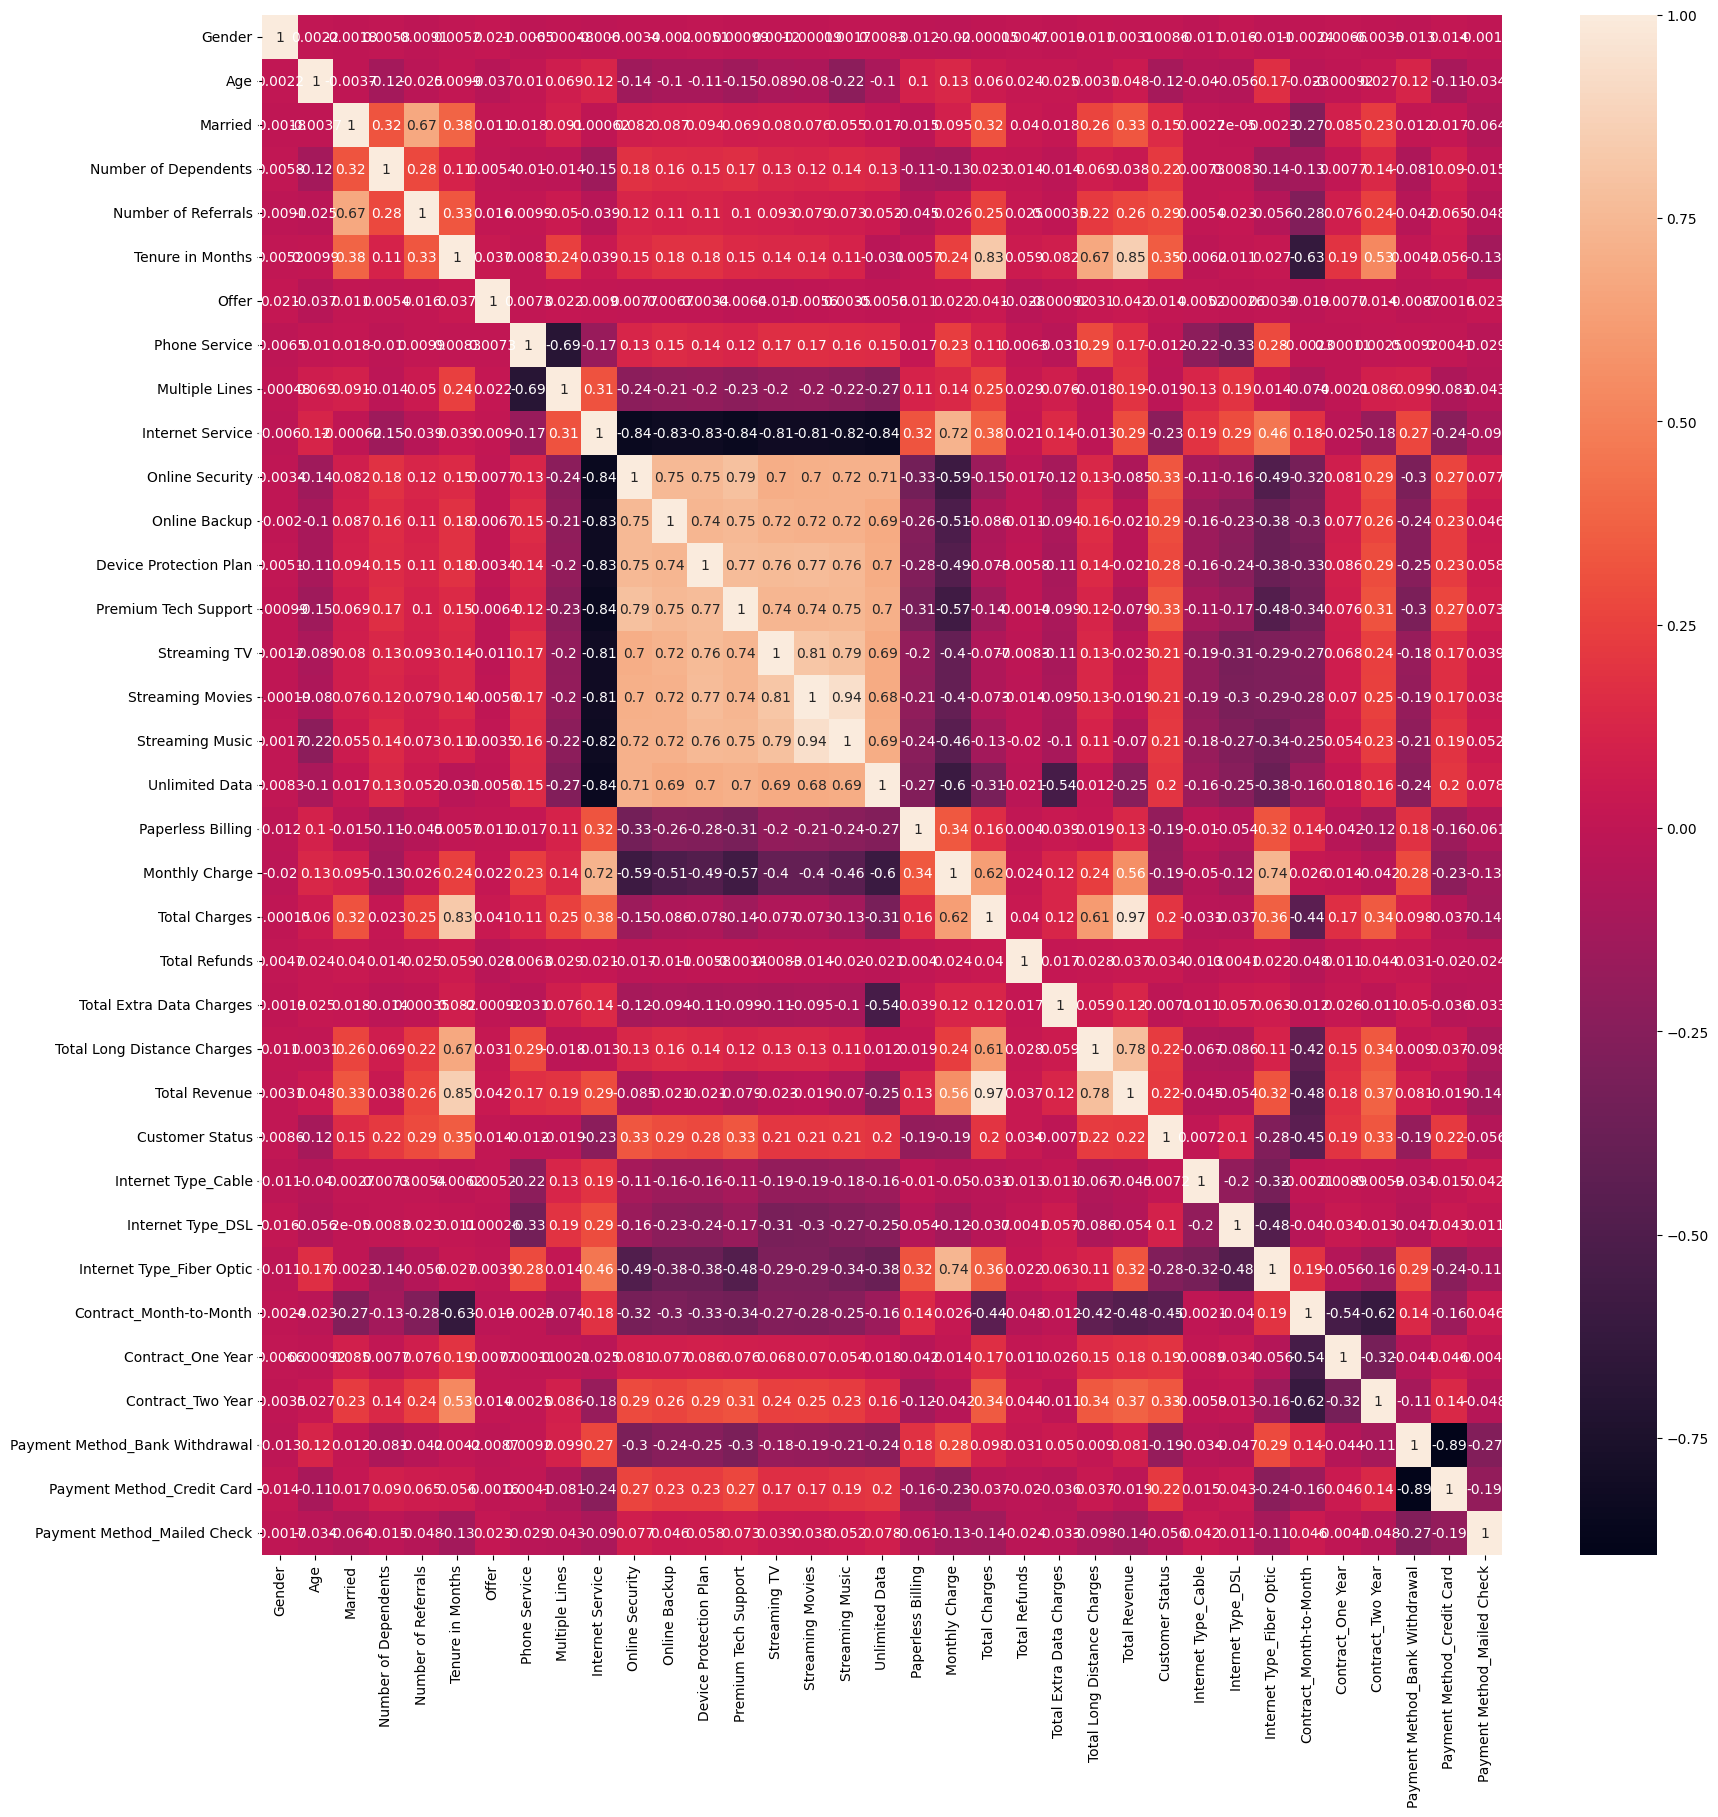

In [30]:
plt.figure(figsize=(20,20))
m_corr = df.corr()
m_corr_top = m_corr.index
sns.heatmap(df[m_corr_top].corr(), annot=True)

### Data preprocessing

Vamos a obtener más información y convertiremos los datos en una representación de datos adecuada para varios algoritmos de aprendizaje automático.

Tengamos en cuenta que el objetivo es crear un **modelo que nos diga si un cliente es Propenso a abandonar la compañia.**

Esta variable se guarda en la Caracteristica Customer Status

También vamos a escalar las caracteristicas numericas.

In [34]:
num_valores_unicos

Gender                               2
Age                                 62
Married                              2
Number of Dependents                10
Number of Referrals                 12
Tenure in Months                    72
Offer                                2
Phone Service                        2
Multiple Lines                       3
Internet Service                     2
Online Security                      3
Online Backup                        3
Device Protection Plan               3
Premium Tech Support                 3
Streaming TV                         3
Streaming Movies                     3
Streaming Music                      3
Unlimited Data                       3
Paperless Billing                    2
Monthly Charge                    1591
Total Charges                     6540
Total Refunds                      500
Total Extra Data Charges            16
Total Long Distance Charges       6068
Total Revenue                     6975
Customer Status          

### Escalado de variables numéricas con valores divergentes.

En nuestro caso son tres features que podemos escalar, Esto significa que las características estaran en un rango similar y una vez escaladas tendrán una media de 0 y una desviación estándar de 1. Ayuda a equilibrar las características, mejorar la convergencia, evitar problemas de sensibilidad, por el ejemplo KNN es muy sensible a las escalas de las caracteristicas 

[Escalado de caracteristicas] (https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.MinMaxScaler.html) #sklearn.preprocessing.MinMaxScaler

In [37]:
from sklearn.preprocessing import MinMaxScaler

# Seleccionar las columnas a escalar
columns_to_scale = ['Age','Tenure in Months', 'Total Charges', 'Monthly Charge',
                   'Total Long Distance Charges','Total Revenue','Total Refunds',
                    'Total Extra Data Charges'
                   ]

# Crear una instancia del MinMaxScaler
scaler = MinMaxScaler()

# Ajustar y transformar las columnas seleccionadas
df[columns_to_scale] = scaler.fit_transform(df[columns_to_scale])

# Mostrar el DataFrame resultante
df

,Gender,Age,Married,Number of Dependents,Number of Referrals,Tenure in Months,Offer,Phone Service,Multiple Lines,Internet Service,...,Customer Status,Internet Type_Cable,Internet Type_DSL,Internet Type_Fiber Optic,Contract_Month-to-Month,Contract_One Year,Contract_Two Year,Payment Method_Bank Withdrawal,Payment Method_Credit Card,Payment Method_Mailed Check
0,0,0.295082,1,0,2,0.112676,False,1,0,1,...,1,True,False,False,False,True,False,False,True,False
1,1,0.442623,0,0,0,0.112676,False,1,1,1,...,1,True,False,False,True,False,False,False,True,False
2,1,0.508197,0,0,0,0.042254,True,1,0,1,...,0,False,False,True,True,False,False,True,False,False
3,1,0.967213,1,0,1,0.169014,True,1,0,1,...,0,False,False,True,True,False,False,True,False,False
4,0,0.918033,1,0,3,0.028169,False,1,0,1,...,0,False,False,True,True,False,False,False,True,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7038,0,0.016393,0,0,0,0.169014,True,1,0,1,...,1,False,True,False,False,True,False,False,True,False
7039,1,0.344262,1,0,1,0.295775,True,1,1,1,...,0,False,False,True,True,False,False,True,False,False
7040,1,0.049180,0,0,0,0.014085,True,1,0,1,...,1,False,True,False,True,False,False,False,True,False
7041,1,0.032787,1,0,5,0.929577,True,1,0,1,...,1,True,False,False,False,False,True,False,True,False


In [40]:
print(nan_values,'\n')

Gender                            0
Age                               0
Married                           0
Number of Dependents              0
Number of Referrals               0
Tenure in Months                  0
Offer                             0
Phone Service                     0
Multiple Lines                    0
Internet Service                  0
Online Security                   0
Online Backup                     0
Device Protection Plan            0
Premium Tech Support              0
Streaming TV                      0
Streaming Movies                  0
Streaming Music                   0
Unlimited Data                    0
Paperless Billing                 0
Monthly Charge                    0
Total Charges                     0
Total Refunds                     0
Total Extra Data Charges          0
Total Long Distance Charges       0
Total Revenue                     0
Customer Status                   0
Internet Type_Cable               0
Internet Type_DSL           

### Perfecto, al parecer ya tenemos un dataset mas o menos limpio y procesado. pero ahora empieza lo bueno.

Vamos a mirar las correlaciones que tienen las demas caracteristicas con nuestra variable objetivo, para ver cuales se quedan cuales se van y cuales son ams importantes.

### La correlación mide la relación lineal entre dos variables. Las características con alta correlación son más linealmente dependientes y tienen casi el mismo efecto sobre la variable dependiente. 

### Cuando dos características tienen una correlación alta, podemos descartar una de ellas. En nuestro caso, podemos eliminar características altamente correlacionadas.

<span style="color:red">Multiple Lines, Online Security, OnlineBackup, DeviceProtection, Premium Tech Support, Streaming TV y Streaming Movies y **quedarnos solo con una de ellas**.<span> 
    
De momento se las puedo dejar porque no estan excesivamente correlacionadas.

In [254]:
### Eliminando columnas altamentes relacionadas unas con otras para evitar sobreajuste.
### Ya habia eliminado mas anteriormente

# df = df.drop(['Churn_Category_Competitor', 'Churn_Category_no_Churn', 'Total_Charge'], axis=1)

<Axes: >

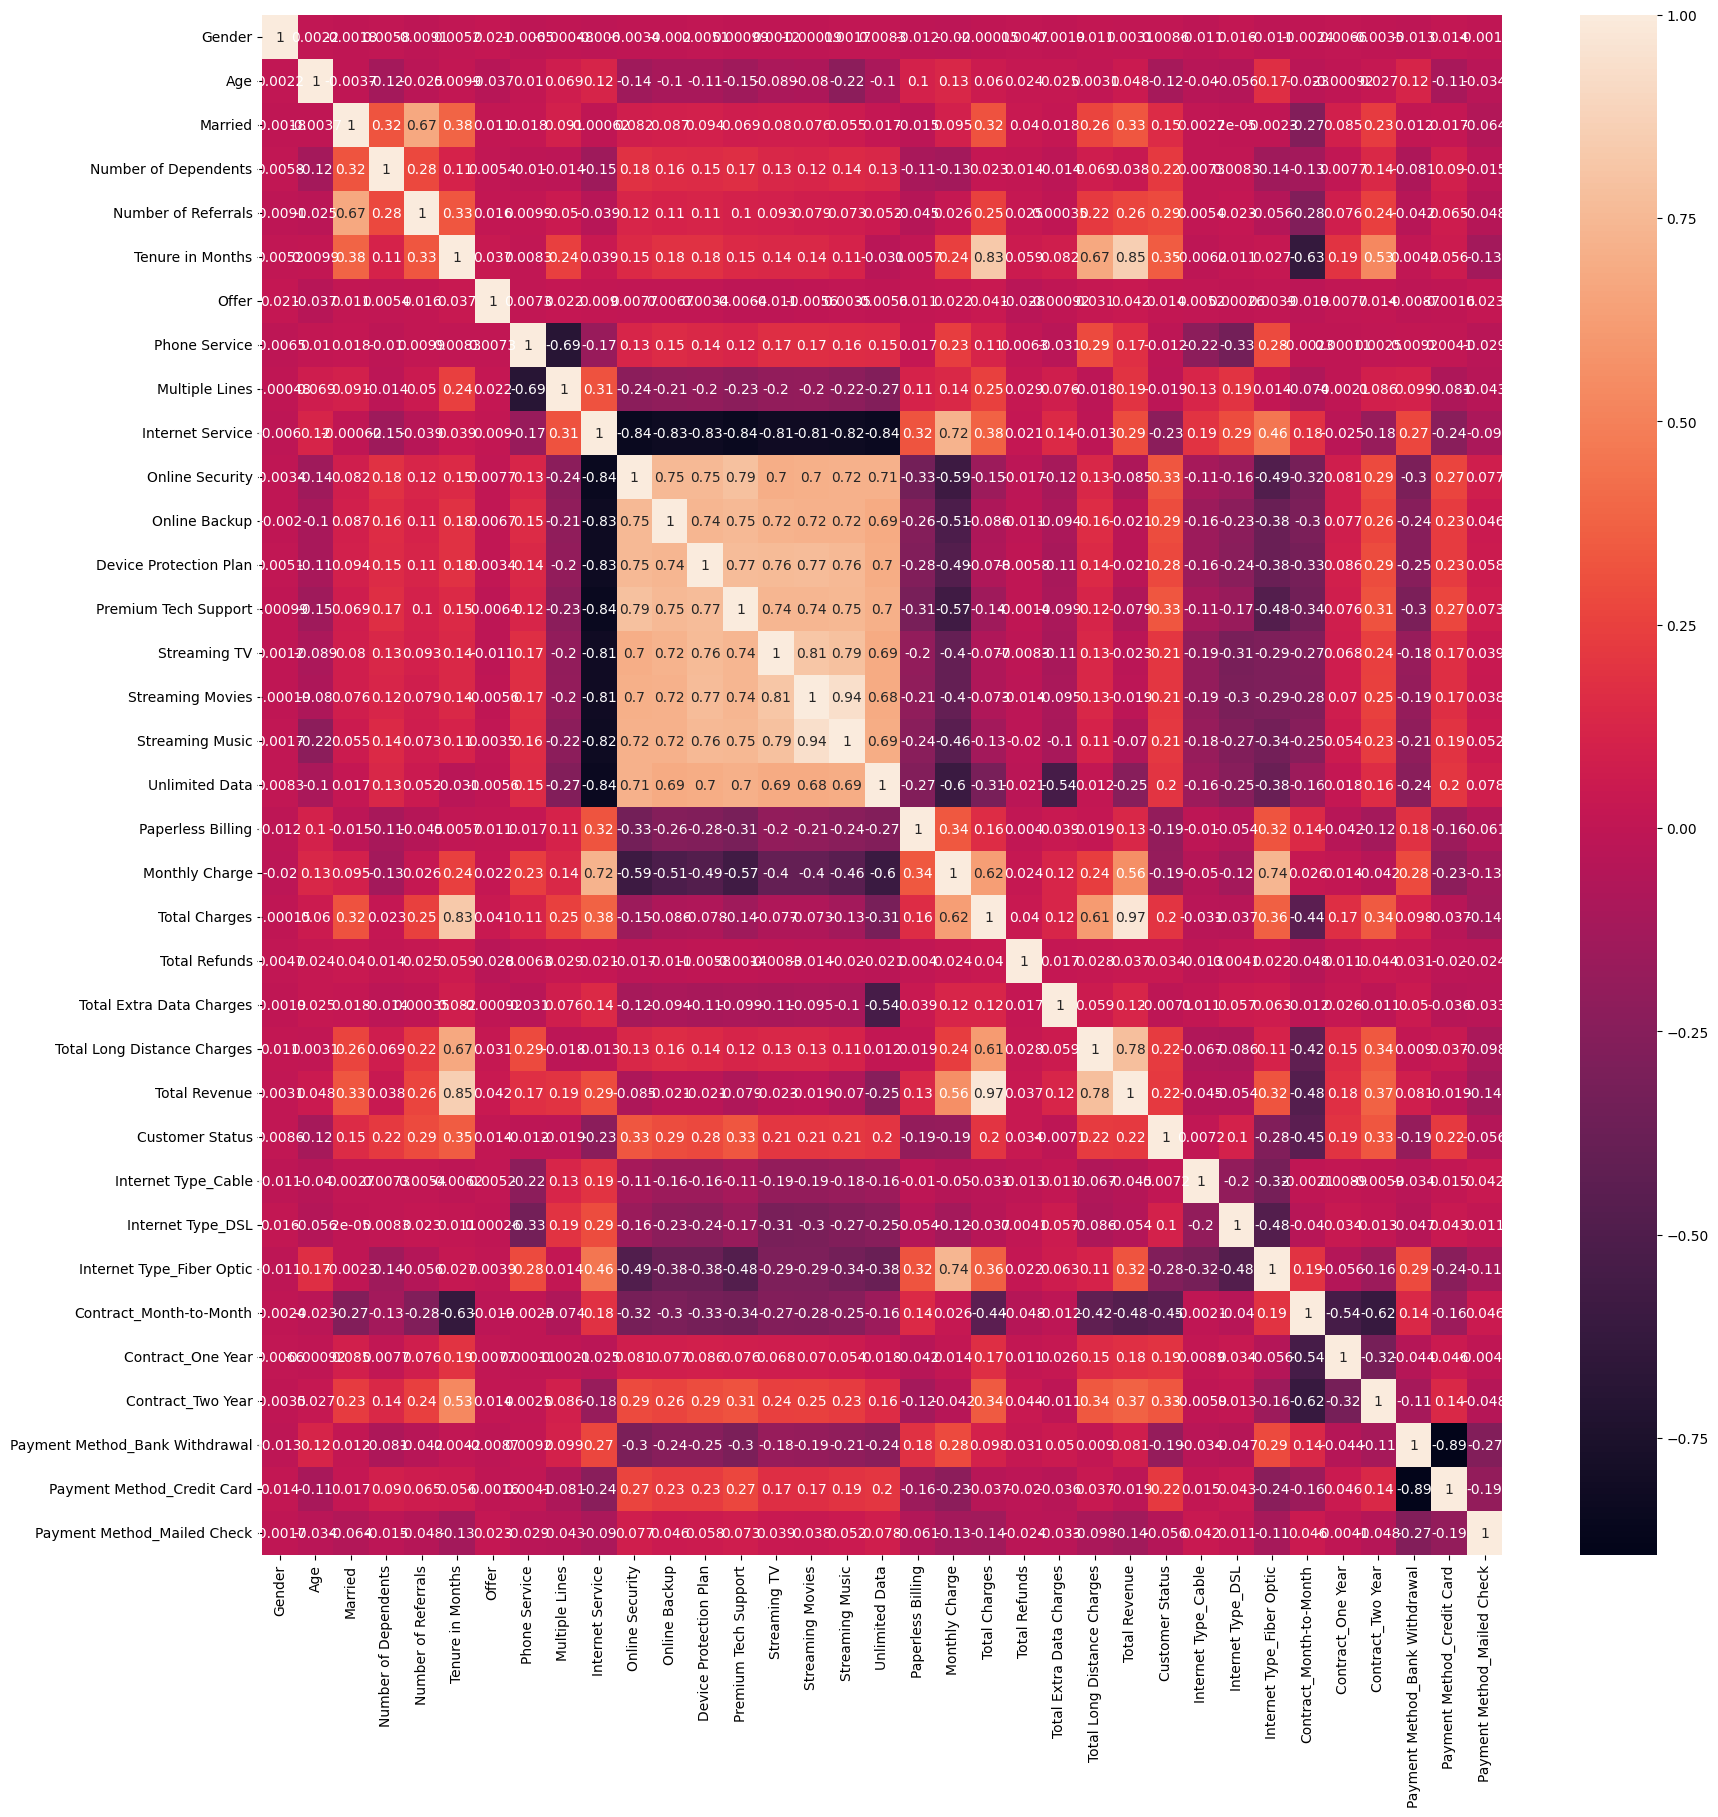

In [43]:
plt.figure(figsize=(20,20))
m_corr = df.corr()
m_corr_top = m_corr.index
sns.heatmap(df[m_corr_top].corr(), annot=True)

In [89]:
# Funcion Para eliminar columnas si fuera necesario en este caso Total Revenue Esta muy Relacioanda con Total Charges

def eliminar_columna(dataframe, columna):
    if columna in dataframe.columns:
        # Eliminar la columna
        dataframe.drop(columna, axis=1, inplace=True)
        print("Columna '{}' eliminada correctamente.".format(columna))
    else:
        print("La columna '{}' no existe en el DataFrame.".format(columna))

In [90]:
eliminar_columna(df, 'Total Revenue')

Columna 'Total Revenue' eliminada correctamente.


Vamos a crear el conjunto de prueba y de entrenamiento, sabemos que nuestra variable objetivo (Customer Status) está desbalanceada con mas casos de abandono negativos que positivos, por eso nos ayudaremos de el <span style="color:red">hiperparametro de train_test_split "Stratify = y"</span>, este le debemos igualara con los datos variable objetivo(y). Y creará la misma cantidad de caracteristicas en ambos casos para que el modelo no se vea sesgado por la mayoria de caracteristicas de clientes que no han abandonado.

En otros casos se puede usar oversampling con tecnicas como **SMOTE**, que se refiere a crear datos ficticios a partir de la variable minoritaria. pero en este caso probaremos de esta manera y luego probaremos con SMOTE.



In [91]:
X = df.drop('Customer Status', axis=1)
y = df['Customer Status']

In [92]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, stratify = y, test_size=0.2, random_state=42)


In [93]:
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

In [94]:
# CHURN = 0
# NO CHURN = 1

from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report

# Predecimos con regresion logistica.

lr = LogisticRegression(max_iter = 1000)

lr.fit(X_train, y_train)

lr_pred = lr.predict(X_test)
lr_accuracy = accuracy_score(y_test, lr_pred)
lr_precision = precision_score(y_test, lr_pred)
lr_recall = recall_score(y_test, lr_pred)
lr_f1 = f1_score(y_test, lr_pred)
lr_report = classification_report(y_test, lr_pred)

print("Logistic Regression:")
print("Accuracy:", lr_accuracy)
print("Precision:", lr_precision)
print("Recall:", lr_recall)
print("F1-score:", lr_f1)
print("\nClassification Report:\n", lr_report)
print('----------------------------------------------------------------')
# Arboles de Decision

dt = DecisionTreeClassifier()

dt.fit(X_train, y_train)

dt_pred = dt.predict(X_test)
dt_accuracy = accuracy_score(y_test, dt_pred)
dt_precision = precision_score(y_test, dt_pred)
dt_recall = recall_score(y_test, dt_pred)
dt_f1 = f1_score(y_test, dt_pred)
dt_report = classification_report(y_test, dt_pred)

print("Decision Tree:")
print("Accuracy:", dt_accuracy)
print("Precision:", dt_precision)
print("Recall:", dt_recall)
print("F1-score:", dt_f1)
print("\nClassification Report:\n", dt_report)
print('----------------------------------------------------------------')
# Random Forest

rf = RandomForestClassifier()

rf.fit(X_train, y_train)

rf_pred = rf.predict(X_test)
rf_accuracy = accuracy_score(y_test, rf_pred)
rf_precision = precision_score(y_test, rf_pred)
rf_recall = recall_score(y_test, rf_pred)
rf_f1 = f1_score(y_test, rf_pred)
rf_report = classification_report(y_test, rf_pred)

print("Random Forest:")
print("Accuracy:", rf_accuracy)
print("Precision:", rf_precision)
print("Recall:", rf_recall)
print("F1-score:", rf_f1)
print("\nClassification Report:\n", rf_report)


Logistic Regression:
Accuracy: 0.8559261887863733
Precision: 0.8931947069943289
Recall: 0.9130434782608695
F1-score: 0.9030100334448161

Classification Report:
               precision    recall  f1-score   support

           0       0.74      0.70      0.72       374
           1       0.89      0.91      0.90      1035

    accuracy                           0.86      1409
   macro avg       0.82      0.81      0.81      1409
weighted avg       0.85      0.86      0.85      1409

----------------------------------------------------------------
Decision Tree:
Accuracy: 0.7998580553584103
Precision: 0.8673170731707317
Recall: 0.8589371980676328
F1-score: 0.8631067961165048

Classification Report:
               precision    recall  f1-score   support

           0       0.62      0.64      0.63       374
           1       0.87      0.86      0.86      1035

    accuracy                           0.80      1409
   macro avg       0.74      0.75      0.75      1409
weighted avg       0

### Muy Buenos resultados, pero ahora vamos a evaluarlos.

En los modelos de ML en clasificacion podemos usar ciertas metricas.

Precisión: La precisión mide la proporción de ejemplos positivos que fueron clasificados correctamente como positivos, es decir, la capacidad del modelo para no etiquetar incorrectamente ejemplos negativos como positivos. **Se calcula dividiendo el número de verdaderos positivos (TP) entre la suma de los verdaderos positivos y los falsos positivos (FP):

**Precisión = TP / (TP + FP)**

Recall: También conocido como sensibilidad o tasa de verdaderos positivos, el recall mide la proporción de ejemplos positivos que fueron clasificados correctamente como positivos en relación con todos los ejemplos positivos reales.

**Recall = TP / (TP + FN)**

**F1 score = (media) * (precision * recall) / (precision + recall)**


## Evaluacion del modelo con Análisis de la Curva ROC y AUC (Area under the curve)

[Curva ROC] (https://es.wikipedia.org/wiki/Curva_ROC)

La curva ROC (Receiver Operating Characteristic) y el área bajo la curva (AUC) son métricas utilizadas para evaluar el rendimiento de un modelo de machine learning en problemas de clasificación binaria.

En términos sencillos, la curva ROC representa la relación entre la tasa de verdaderos positivos (recall o sensibilidad) y la tasa de falsos positivos (1 - especificidad) a medida que se ajusta el umbral de clasificación del modelo. La curva ROC muestra cómo el modelo equilibra la capacidad para identificar correctamente las instancias positivas (verdaderos positivos) y la tasa de clasificar incorrectamente las instancias negativas como positivas (falsos positivos).

El área bajo la curva (AUC) es una métrica numérica que resume el rendimiento de la curva ROC. El valor del AUC varía entre 0 y 1, donde un valor de 1 indica un modelo perfecto que clasifica correctamente todas las instancias(en la mayoria de casos no sería deseable ya que indica sobreajuste hacia los dato de entrenamiento) y un valor de 0.5 indica que el modelo clasifica aleatoriamente.

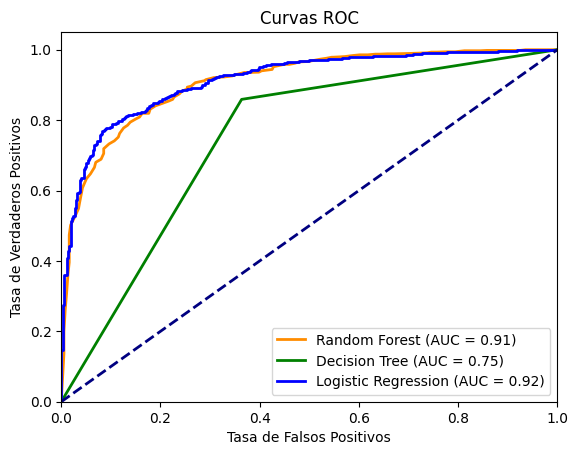

In [97]:
probas_rf = rf.predict_proba(X_test)[:, 1]
probas_dt = dt.predict_proba(X_test)[:, 1]
probas_lr = lr.predict_proba(X_test)[:, 1]

# Calcular las tasas de verdaderos positivos, las tasas de falsos positivos y los umbrales para cada modelo
fpr_rf, tpr_rf, thresholds_rf = roc_curve(y_test, probas_rf)
fpr_dt, tpr_dt, thresholds_dt = roc_curve(y_test, probas_dt)
fpr_lr, tpr_lr, thresholds_lr = roc_curve(y_test, probas_lr)

# Calcular el área bajo la curva ROC (AUC) para cada modelo
roc_auc_rf = auc(fpr_rf, tpr_rf)
roc_auc_dt = auc(fpr_dt, tpr_dt)
roc_auc_lr = auc(fpr_lr, tpr_lr)

# Trazar las curvas ROC para cada modelo en una misma figura
plt.figure()
plt.plot(fpr_rf, tpr_rf, color='darkorange', lw=2, label='Random Forest (AUC = %0.2f)' % roc_auc_rf)
plt.plot(fpr_dt, tpr_dt, color='green', lw=2, label='Decision Tree (AUC = %0.2f)' % roc_auc_dt)
plt.plot(fpr_lr, tpr_lr, color='blue', lw=2, label='Logistic Regression (AUC = %0.2f)' % roc_auc_lr)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Tasa de Falsos Positivos')
plt.ylabel('Tasa de Verdaderos Positivos')
plt.title('Curvas ROC')
plt.legend(loc="lower right")
plt.show()

### Excelente!!

* -- EL mejor es el Modelo es de Regresión Lineal (lr) me da un AUC de 0.92
* -- Arboles de decision (dt) de 0.75
* -- Bosques aleatorios o Random Forest (rf), tiene un AUC DE 0.91 y tiene mejor precission que el Modelo de Regresion lineal 

### Vamos a probar con XGBoost

**XGBoost (Extreme Gradient Boosting)** es un algoritmo que se utiliza para problemas de clasificación y regresión. Aunque este dataset no es especialmente el caso, XGBOOST es conocido por su eficacia y su capacidad para manejar grandes conjuntos de datos.

**XGBoost utiliza árboles de decisión debiles o *weak* para luego aplicarle un proceso llamado boosting**, que básicamente es crear muchos arboles pequeños diferentes y unirlos mejorando gradualmente la precisión del modelo y agregando árboles sucesivamente. En cada iteración, se calcula un gradiente que representa el error del modelo actual. 

In [59]:
# Aunque no es necesario, siempre me gusta Crear una matriz DMatrix para mejorar el rendimiento de xgboost.
# Los datos de entrenamiento ya los tenemos creados.

dtrain = xgb.DMatrix(X_train, label=y_train)
dtest = xgb.DMatrix(X_test, label=y_test)

# Definir los parámetros del modelo
params = {
    'max_depth': 3,
    'eta': 0.1,
    'objective': 'binary:logistic',
    'eval_metric': 'logloss'
}

# Entrenar el modelo
num_round = 100
model = xgb.train(params, dtrain, num_round)

# Paso 6: Realizar predicciones con el conjunto de prueba
y_pred = model.predict(dtest)
y_pred_binary = [1 if pred > 0.5 else 0 for pred in y_pred]

# Paso 7: Evaluar el rendimiento del modelo
accuracy = accuracy_score(y_test, y_pred_binary)
precision = precision_score(y_test, y_pred_binary)
recall = recall_score(y_test, y_pred_binary)
f1 = f1_score(y_test, y_pred_binary)

print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1-score:", f1)

Accuracy: 0.8623136976579134
Precision: 0.892623716153128
Recall: 0.923671497584541
F1-score: 0.9078822412155745


### Aunque los de arriba son muy buenos resultados, XGBoost los mejora. con un AUC de 0.93

XGBoost da unos resultados excelentes y es normal ya que es primo del modelo Random Forest que son la implementacion de bagging para arboles de decision. a diferencia de xgboost que aplica boosting, pero, el caso es que estos **dos modelos dan resultados francamente excelentes.**

AUC: 0.927440646877987


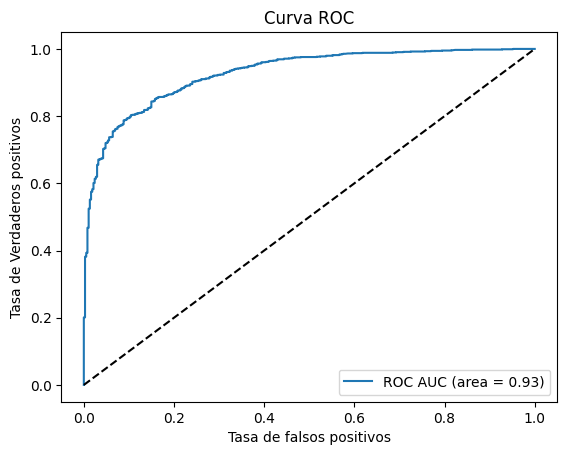

In [61]:
from sklearn.metrics import roc_curve, auc
y_prob = model.predict(dtest)
fpr, tpr, thresholds = roc_curve(y_test, y_prob)
roc_auc = auc(fpr, tpr)
print("AUC:", roc_auc)
import matplotlib.pyplot as plt

plt.plot(fpr, tpr, label='ROC AUC (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], 'k--')  # Línea de referencia para una clasificación aleatoria
plt.xlabel('Tasa de falsos positivos')
plt.ylabel('Tasa de Verdaderos positivos')
plt.title('Curva ROC')
plt.legend(loc='lower right')
plt.show()


### Veamos que tal los resultados si, en vez de aplicar stratify en el split, usamos SMOTE (Synthetic Minority Over-sampling Technique)  para abordar el desequilibrio de clases en los datos. 

En Machine Learning, cuando nos encontramos con conjuntos de datos en los que una clase es mucho más frecuente que la otra. Esto puede llevar a un **sesgo en el modelo**, donde el modelo puede tener dificultades para aprender patrones de la clase minoritaria debido a la escasez de ejemplos.

SMOTE aborda este desequilibrio de clases generando nuevos ejemplos ficticios de la clase minoritaria. Estos ejemplos se crean mediante interpolación y selección aleatoriamente de un ejemplo de la clase minoritaria y encuentra sus vecinos más cercanos. Esto permite que el modelo aprenda de manera más efectiva los patrones de la clase minoritaria y mejore su capacidad para clasificar correctamente las instancias de ambas clases.

In [65]:
from imblearn.over_sampling import SMOTE

In [78]:
smote = SMOTE(sampling_strategy='minority')  # Por ejemplo, con minority igualamos el tamaño de la clase minoritaria

In [79]:
X_resampled, y_resampled = smote.fit_resample(X, y)

In [80]:
Xr_train, Xr_test, yr_train, yr_test = train_test_split(X_resampled, y_resampled, test_size=0.2, random_state=42)

In [81]:
lr.fit(Xr_train, yr_train)
dt.fit(Xr_train, yr_train)
rf.fit(Xr_train, yr_train)

RandomForestClassifier()

In [82]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report

# Logistic Regression
lr_pred = lr.predict(Xr_test)
lr_accuracy = accuracy_score(yr_test, lr_pred)
lr_precision = precision_score(yr_test, lr_pred)
lr_recall = recall_score(yr_test, lr_pred)
lr_f1 = f1_score(yr_test, lr_pred)
lr_report = classification_report(yr_test, lr_pred)

print("Logistic Regression:")
print("Accuracy:", lr_accuracy)
print("Precision:", lr_precision)
print("Recall:", lr_recall)
print("F1-score:", lr_f1)
print("Classification Report:\n", lr_report)

# Decision Tree
dt_pred = dt.predict(Xr_test)
dt_accuracy = accuracy_score(yr_test, dt_pred)
dt_precision = precision_score(yr_test, dt_pred)
dt_recall = recall_score(yr_test, dt_pred)
dt_f1 = f1_score(yr_test, dt_pred)
dt_report = classification_report(yr_test, dt_pred)

print("Decision Tree:")
print("Accuracy:", dt_accuracy)
print("Precision:", dt_precision)
print("Recall:", dt_recall)
print("F1-score:", dt_f1)
print("Classification Report:\n", dt_report)

# Random Forest
rf_pred = rf.predict(Xr_test)
rf_accuracy = accuracy_score(yr_test, rf_pred)
rf_precision = precision_score(yr_test, rf_pred)
rf_recall = recall_score(yr_test, rf_pred)
rf_f1 = f1_score(yr_test, rf_pred)
rf_report = classification_report(yr_test, rf_pred)

print("Random Forest:")
print("Accuracy:", rf_accuracy)
print("Precision:", rf_precision)
print("Recall:", rf_recall)
print("F1-score:", rf_f1)
print("Classification Report:\n", rf_report)

Logistic Regression:
Accuracy: 0.836231884057971
Precision: 0.8495934959349594
Recall: 0.8140214216163584
F1-score: 0.8314271506713079
Classification Report:
               precision    recall  f1-score   support

           0       0.82      0.86      0.84      1043
           1       0.85      0.81      0.83      1027

    accuracy                           0.84      2070
   macro avg       0.84      0.84      0.84      2070
weighted avg       0.84      0.84      0.84      2070

Decision Tree:
Accuracy: 0.8318840579710145
Precision: 0.8224121557454891
Recall: 0.8432327166504382
F1-score: 0.8326923076923077
Classification Report:
               precision    recall  f1-score   support

           0       0.84      0.82      0.83      1043
           1       0.82      0.84      0.83      1027

    accuracy                           0.83      2070
   macro avg       0.83      0.83      0.83      2070
weighted avg       0.83      0.83      0.83      2070

Random Forest:
Accuracy: 0.883091

<span style="color:green">Vemos claramente que al hacer **oversampling con SMOTE** el modelo se vuelve casi perfecto, con unas tasas de precision, recall y f1 muy buenas para el para el conjunto de pruebas, con **stratify = y** también daba muy buenos resultados pero no alcanzaba el nivel de oversampling a la hora de predecir en el conjunto de datos nuevo.</span>

### Para hacerlo mas claro, la curva ROC AUC, de el modelo despues de aplicar oversampling.

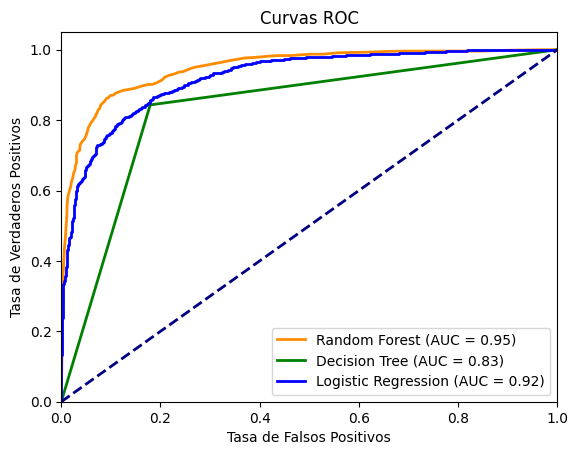

In [87]:
# Obtener las probabilidades de la clase positiva para cada modelo
probas_rf = rf.predict_proba(Xr_test)[:, 1]
probas_dt = dt.predict_proba(Xr_test)[:, 1]
probas_lr = lr.predict_proba(Xr_test)[:, 1]

# Calcular las tasas de verdaderos positivos, las tasas de falsos positivos y los umbrales para cada modelo
fpr_rf, tpr_rf, thresholds_rf = roc_curve(yr_test, probas_rf)
fpr_dt, tpr_dt, thresholds_dt = roc_curve(yr_test, probas_dt)
fpr_lr, tpr_lr, thresholds_lr = roc_curve(yr_test, probas_lr)

# Calcular el área bajo la curva ROC (AUC) para cada modelo
roc_auc_rf = auc(fpr_rf, tpr_rf)
roc_auc_dt = auc(fpr_dt, tpr_dt)
roc_auc_lr = auc(fpr_lr, tpr_lr)

# Trazar las curvas ROC para cada modelo en una misma figura
plt.figure()
plt.plot(fpr_rf, tpr_rf, color='darkorange', lw=2, label='Random Forest (AUC = %0.2f)' % roc_auc_rf)
plt.plot(fpr_dt, tpr_dt, color='green', lw=2, label='Decision Tree (AUC = %0.2f)' % roc_auc_dt)
plt.plot(fpr_lr, tpr_lr, color='blue', lw=2, label='Logistic Regression (AUC = %0.2f)' % roc_auc_lr)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Tasa de Falsos Positivos')
plt.ylabel('Tasa de Verdaderos Positivos')
plt.title('Curvas ROC')
plt.legend(loc="lower right")
plt.show()


In [96]:
feature_names = X_train.columns
print("Feature Names:", feature_names)

Feature Names: Index(['Gender', 'Age', 'Married', 'Number of Dependents',
       'Number of Referrals', 'Tenure in Months', 'Offer', 'Phone Service',
       'Multiple Lines', 'Internet Service', 'Online Security',
       'Online Backup', 'Device Protection Plan', 'Premium Tech Support',
       'Streaming TV', 'Streaming Movies', 'Streaming Music', 'Unlimited Data',
       'Paperless Billing', 'Monthly Charge', 'Total Charges', 'Total Refunds',
       'Total Extra Data Charges', 'Total Long Distance Charges',
       'Internet Type_Cable', 'Internet Type_DSL', 'Internet Type_Fiber Optic',
       'Contract_Month-to-Month', 'Contract_One Year', 'Contract_Two Year',
       'Payment Method_Bank Withdrawal', 'Payment Method_Credit Card',
       'Payment Method_Mailed Check'],
      dtype='object')
